In [1]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [9]:
class AgentState(TypedDict):
    name : str
    number : List[int]
    counter: int

In [10]:
def greeting_node(state: AgentState) -> AgentState:
    """Node says Hi to the person"""

    
    state["name"] = f"Hi there, {state["name"]}"
    state["counter"] = 0

    return state

def random_node(state: AgentState) -> AgentState:
    """Node generates a random number from 1 to 10  """
    state["number"].append(random.randint(1, 10))
    state["counter"] += 1
    return state


def should_continue(state: AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop


In [11]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random",  
        "exit": END          
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

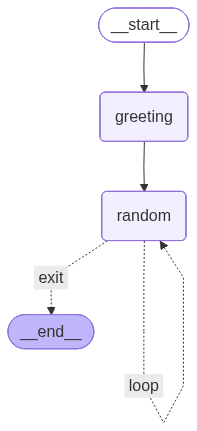

In [6]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
app.invoke({"name": "Bob", "number": [], "counter": -1})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, Bob', 'number': [6, 7, 10, 7, 6], 'counter': 5}

In [21]:
# Exercise - 5
# Automatic Higher or Lower Game.
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict


In [25]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 

def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")

    return state

def hint_node(state: GameState) -> GameState:
    """Provide hints based on the latest guess"""
    last_guess = state["guesses"][-1]
    target = state["target_number"]

    if last_guess < target:
        state["hint"] = f"The number {last_guess} is too low!, Try Higher"

        state["lower_bound"] = max(state["lower_bound"], last_guess + 1)
        print(f"Hint: {state['hint']}")
    
    elif last_guess > target:
        state["hint"] = f"The number {last_guess} is too high!, Try Lower"

        state["upper_bound"] = min(state["upper_bound"], last_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Congratulations! You've guessed the number {target} in {state['attempts']} attempts."
        print(f"Success {state["hint"]}")

    return state

def should_continue(state: GameState) -> GameState:
    """Decide whether to continue guessing or end the game"""
    last_guess = state["guesses"][-1]
    if last_guess == state["target_number"]:
        print("Game over , Number found !")
        return "end"
    elif state["attempts"] >= 7:
        print(f"Game over , Maximum attempts reached !, The number was {state['target_number']}")
        return "end"
    else:
        print(f"Continuing the game , Attempts so far : {state['attempts']}")
        return "continue"
        

In [26]:
graph = StateGraph(GameState)

graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint", hint_node)

graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint")

graph.add_conditional_edges(
    "hint",
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)
graph.set_entry_point("setup")
app = graph.compile()

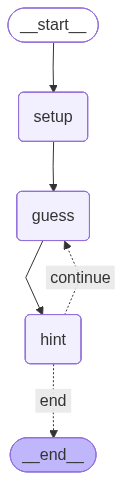

In [27]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
result = app.invoke({"player_name": "Alice", "guesses": [], "attempts": 0,  "lower_bound":1, "upper_bound":20})

Welcome, Alice! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 10 (Current range: 1-20)
Success Congratulations! You've guessed the number 10 in 1 attempts.
Game over , Number found !
